# Deep Learning Grid Search

Initial exploration of NSQIP processed data and readmission classification potential

In [1]:
import sys
import pandas
import numpy
import sklearn
import keras
import tensorflow as tf
import xgboost

print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pandas.__version__))
print('Numpy: {}'.format(numpy.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.0.3
Numpy: 1.18.1
Sklearn: 0.22.1
Keras: 2.3.1


In [2]:
import pandas as pd
import numpy as np

# import the processed dataset
df = pd.read_csv('../data/processed/NSQIP_Clean2.csv')

In [3]:
# Describe the dataset
df.describe()

,Unnamed: 0,index,READMISSION1,SMOKE,HXCOPD,HYPERMED,DISCANCR,WNDINF,STEROID,WTLOSS,...,OPTIME,TOTHLOS,PRSODM,PRBUN,PRCREAT,PRALBUM,PRPLATE,PRPTT,PRINR,PRPT
count,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,...,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000
mean,1004.790091,1004.790091,0.095828,0.132334,0.019557,0.451108,0.018905,0.001956,0.110169,0.011734,...,0.039475,0.014680,0.040770,0.045461,0.049931,0.018751,0.038299,0.019667,0.057454,-0.310162
std,445.941986,445.941986,0.294451,0.338964,0.138516,0.497766,0.136233,0.044194,0.313203,0.107721,...,1.049078,0.951713,0.931274,0.942819,0.920126,1.003420,0.947258,0.994932,0.966301,0.562898
min,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.683243,-11.505392,-3.517534,-2.568833,-3.325918,-0.839085,-2.845054,-1.330860,-1.696501,-0.429450
25%,622.250000,622.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.613731,-0.279138,0.243796,0.234812,0.293387,-0.839085,-0.240962,-1.330860,0.586251,-0.429450
50%,1005.500000,1005.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.215285,-0.167987,0.275672,0.337698,0.297743,-0.839085,0.146222,0.694512,0.588994,-0.429450
75%,1390.750000,1390.750000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.382384,0.054315,0.307547,0.414863,0.304277,1.190310,0.544469,0.765521,0.588994,-0.429450
max,1774.000000,1774.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,10.584690,12.614380,0.530677,4.530305,0.522089,1.213953,2.907399,1.199645,0.771834,2.612217


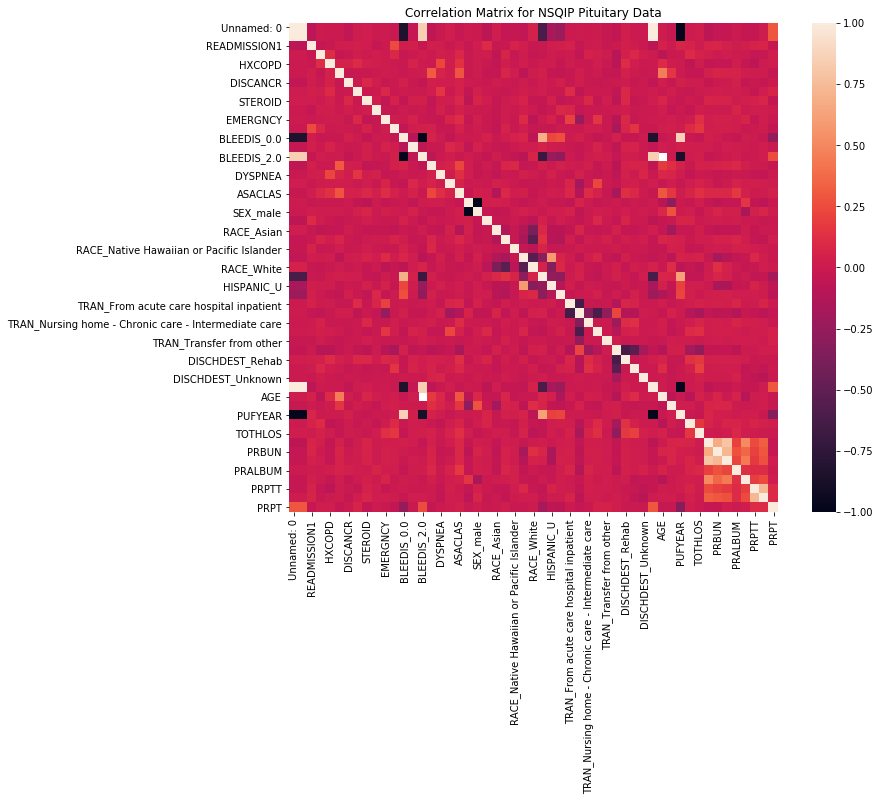

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
data = df

corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = 1, square = True)

plt.title('Correlation Matrix for NSQIP Pituitary Data')
#plt.savefig('../reports/figures/correlation_matrix_4_6_2020.png')
plt.show()

In [16]:
print(corrmat['READMISSION1'].sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last'))

READMISSION1                                            1.000000
RETURNOR                                                0.244676
RACE_American Indian or Alaska Native                   0.097946
PUFYEAR                                                 0.076951
PRBUN                                                   0.070960
PRSODM                                                  0.064475
PRINR                                                   0.063957
OPTIME                                                  0.060723
RACE_Native Hawaiian or Pacific Islander                0.059092
PRPTT                                                   0.056365
TRAN_From acute care hospital inpatient                 0.052378
AGE                                                     0.052347
PRCREAT                                                 0.045239
BLEEDIS_1.0                                             0.037923
DISCHDEST_Rehab                                         0.037307
WNDINF                   

In [5]:
from IPython.display import HTML

data = df
data = data.drop(columns=['index.1', 'index', 'Unnamed: 0']).copy()
# Replace missing values with median values
data['AGE'].replace(np.NaN, data['AGE'].median(), inplace=True)
data = data.dropna()
HTML(pd.DataFrame(data.describe()).to_html())

,READMISSION1,SMOKE,HXCOPD,HYPERMED,DISCANCR,WNDINF,STEROID,WTLOSS,EMERGNCY,RETURNOR,BLEEDIS_0.0,BLEEDIS_1.0,BLEEDIS_2.0,DIABETES,DYSPNEA,PRSEPIS,ASACLAS,SEX_female,SEX_male,RACE_American Indian or Alaska Native,RACE_Asian,RACE_Black or African American,RACE_Native Hawaiian or Pacific Islander,RACE_Unknown/Not Reported,RACE_White,HISPANIC_N,HISPANIC_U,HISPANIC_Y,TRAN_From acute care hospital inpatient,TRAN_Not transferred (admitted from home),TRAN_Nursing home - Chronic care - Intermediate care,TRAN_Outside emergency department,TRAN_Transfer from other,DISCHDEST_Home,DISCHDEST_Rehab,"DISCHDEST_Skilled Care, Not Home",DISCHDEST_Unknown,AGE,WEIGHT,PUFYEAR,OPTIME,TOTHLOS,PRSODM,PRBUN,PRCREAT,PRALBUM,PRPLATE,PRPTT,PRINR,PRPT
count,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000
mean,0.095238,0.132420,0.019569,0.450750,0.018917,0.001957,0.110241,0.011742,0.022831,0.043705,0.596869,0.005219,0.397913,0.183953,0.033920,0.011089,0.647913,0.497717,0.502283,0.003262,0.075669,0.139596,0.003262,0.144162,0.629485,0.427267,0.078278,0.096543,0.018917,0.954338,0.005219,0.016960,0.003262,0.941292,0.023483,0.016308,0.001957,0.026155,-0.012054,0.278520,0.040004,0.013494,0.040544,0.045120,0.049754,0.017983,0.038107,0.020548,0.058598,-0.310085
std,0.293639,0.339058,0.138561,0.497731,0.136277,0.044209,0.313293,0.107756,0.149413,0.204505,0.490687,0.072074,0.489627,0.387572,0.181083,0.104755,0.157283,0.500158,0.500158,0.057036,0.264553,0.346680,0.057036,0.351368,0.483100,0.494843,0.268696,0.295430,0.136277,0.208819,0.072074,0.129164,0.057036,0.235155,0.151482,0.126698,0.044209,0.780166,0.995876,0.587100,1.049216,0.950889,0.931535,0.943032,0.920401,1.003296,0.947537,0.994657,0.965576,0.563074
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.220814,-5.202635,-0.702101,-1.683243,-11.505392,-3.517534,-2.568833,-3.325918,-0.839085,-2.845054,-1.330860,-1.696501,-0.429450
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.142679,-0.610939,-0.357072,-0.613731,-0.279138,0.243796,0.234812,0.293387,-0.839085,-0.243175,-1.330860,0.586251,-0.429450
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.109216,-0.098789,0.332986,-0.215285,-0.167987,0.275672,0.337698,0.297743,-0.839085,0.146222,0.694512,0.588994,-0.429450
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.298137,0.484004,0.67801

In [8]:
# split into training and testing datasets
# Define a random seed
seed = 6
np.random.seed(seed)

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

# split into input (X) and an output (Y)
Y = train.READMISSION1
X_standardized = train.drop(columns=['READMISSION1'])

Y_test = test.READMISSION1
X_test = test.drop(columns=['READMISSION1'])

In [9]:
print(X_standardized.shape)
print(Y.shape)

(1205, 49)
(1205,)


In [10]:
# import necessary sklearn and keras packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

In [11]:
# Start defining the model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(49, input_dim = 49, kernel_initializer='normal', activation='relu'))
    model.add(Dense(24, input_dim = 49, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

model = create_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 49)                2450      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1200      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 3,675
Trainable params: 3,675
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Do a grid search for learning rate and dropout rate
# import necessary packages
from keras.layers import Dropout

# Start defining the model
def create_model(learn_rate, dropout_rate):
    # create model
    model = Sequential()
    model.add(Dense(98, input_dim = 49, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(49, input_dim = 98, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(24, input_dim = 49, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12, input_dim = 24, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, input_dim = 12, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, epochs = 50, batch_size = 20, verbose = 0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2]
batch_size = [5, 20, 40]
epochs = [10, 50, 100]

# make a dictionary of the grid search parameters
param_grid = dict(learn_rate=learn_rate, dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs)

# define scoring parameters
scorer=sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score)
#scorer=sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), scoring=scorer, refit=True, verbose = 10, n_jobs=8)
grid_results = grid.fit(X_standardized, Y)

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   42.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  8.9min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 11.7min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 15.1min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 18.0min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 20.1min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 25.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 27.3min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 28.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 29.8min
[Parallel(

In [ ]:
# generate predictions with optimal hyperparameters
y_pred = grid.predict(X_test)

In [ ]:
print(y_pred.shape)

In [ ]:
Y_test.value_counts()

In [ ]:
pd.DataFrame(y_pred)[0].value_counts()

In [ ]:
# Generate a classification report
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

In [ ]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(Y_test, y_pred).ravel()
print('{}, {}, {}, {}\n'.format(tn, fp, fn, tp))

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
PPV = tp / (tp + fp)
NPV = tn / (tn + fn)

print('Sensitivity: {}'.format(sensitivity))
print('Specificity: {}'.format(specificity))
print('PPV: {}'.format(PPV))
print('NPV: {}'.format(NPV))